# Controlnet lineart anime

ControlNet　Lineart animeは、拡散モデルの建物、壁紙、人の肌など表層的な質感やテクスチャを変更することができる手法です．

- ドキュメント:https://huggingface.co/lllyasviel/sd-controlnet-canny

<a href="https://colab.research.google.com/github/fuyu-quant/data-science-wiki/blob/main/multimodal/text_to_image/latent_consistency_models.ipynb" target="_blank" rel="noopener noreferrer"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install diffusers==0.23.0
!pip install accelerate==0.24.1
!pip install transformers==4.35.0
!pip install opencv-contrib-python==4.8.0.76
!pip3 install -U xformers --index-url https://download.pytorch.org/whl/cu118
!pip install controlnet_aux==0.0.3
#!pip install torch==2.1.0+cu118

In [ ]:
import torch
print(torch.version.cuda)
# 実行が確認できたcudaのバージョン
# 11.8

11.8


In [ ]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
import numpy as np
from controlnet_aux import LineartAnimeDetector
from transformers import CLIPTextModel
import requests

from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

### 画像の用意

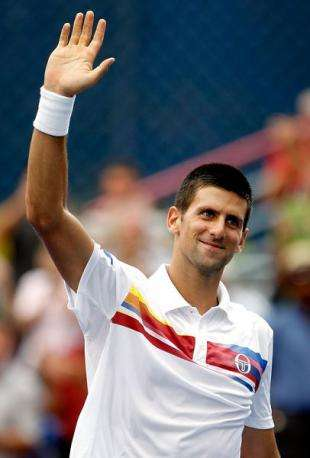

In [13]:
image = load_image("https://huggingface.co/lllyasviel/control_v11p_sd15_openpose/resolve/main/images/input.png")
image

In [ ]:
image = image.resize((512, 512))

processor = LineartAnimeDetector.from_pretrained("lllyasviel/Annotators")

control_image = processor(image)
control_image.save("control.png")
control_image

### Stable Diffusionのダウンロード

In [ ]:
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder", num_hidden_layers=11, torch_dtype=torch.float16)
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15s2_lineart_anime", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", text_encoder=text_encoder, controlnet=controlnet, torch_dtype=torch.float16)

In [20]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
generator = torch.manual_seed(0)

In [ ]:
prompt = ""
nagative_prompt = "paintings, sketches,(worst quality:2),(low quality:2),(normal quality:2)"
image = pipe(prompt, negative_prompt = nagative_prompt, num_inference_steps=30, generator=generator, image=control_image).images[0]
image

In [ ]:
image.save('image_out.png')